## Importing Libraries

In this step, we imported the necessary Python libraries for the project.

In [1]:
#Importing the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-26 16:24:22.957110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758903863.256466      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758903863.344211      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing

- **Training set:**  
  - Normalized the images (`rescale=1./255`).  
  - Applied data augmentation: shear (`shear_range`), zoom (`zoom_range`), and horizontal flip (`horizontal_flip`). 
  - Split 80%-20% for training and validation (`validation_split=0.2`).  

- **Validation set:**  
  - 20% of the training data was reserved for validation.  

- **Test set:**  
  - Only normalized (`rescale=1./255`). 

In [2]:
#Data Preprocessing 
#Preprocessing the Training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

training_set = train_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = "training"
)

validation_set = train_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = "validation"
)

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_test/seg_test",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Building the CNN

- **Input layer:** Takes 150x150 RGB images.  
- **Convolution + Pooling layers:**  
  - Extract features using 3 conv layers (32 → 64 → 128 filters).
  - Apply max pooling after each conv layer to reduce spatial dimensions.  
  - Named the last conv layer `last_conv` → for Grad-CAM.  

- **Flatten:** Converts 2D feature maps into a 1D vector.  
- **Fully connected layers:**  
  - Dense layer with 256 neurons + dropout (0.5) → to reduce overfitting.  
- **Output layer:** Softmax activation for 6 classes

- **Model created:** `keras.Model(inputs, outputs)` 

In [3]:
# Building the CNN
# Input layer
inputs = keras.Input(shape=(150,150,3))

# Convolution + Pooling layers
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Named the last convolutional layer → will be used for Grad-CAM
x = keras.layers.Conv2D(128, 3, activation="relu", name="last_conv")(x)
x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Flattening
x = keras.layers.Flatten()(x)

# Fully connected layers
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

# Output layer
outputs = keras.layers.Dense(6, activation="softmax")(x)  # 6 sınıf

# Modeli oluştur
cnn = keras.Model(inputs=inputs, outputs=outputs)

2025-09-26 16:24:47.779849: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Training the CNN

- **Compile:**  
  - Optimizer: `Adam`  
  - Loss function: `Categorical Crossentropy` (for multi-class classification)  
  - Metric: `Accuracy`  

- **Fit:**  
  - Trained the model using the training data (`training_set`).  
  - Monitored accuracy using the validation set.  
  - Number of epochs: 20

In [4]:
#Training the CNN 
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = cnn.fit(
    training_set,
    validation_data = validation_set,
    epochs = 5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.4538 - loss: 1.3559 - val_accuracy: 0.6537 - val_loss: 0.8731
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.6536 - loss: 0.9129 - val_accuracy: 0.7529 - val_loss: 0.6892
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7239 - loss: 0.7482 - val_accuracy: 0.7825 - val_loss: 0.6379
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.7605 - loss: 0.6675 - val_accuracy: 0.8124 - val_loss: 0.5368
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.7857 - loss: 0.5916 - val_accuracy: 0.8028 - val_loss: 0.5431


## Evaluating on Test Set

- Evaluated the model on the **test set**.
- Calculated and displayed the test accuracy (`Test Accuracy`).

In [5]:
#Evaluating on Test Set
test_loss, test_acc = cnn.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - accuracy: 0.8259 - loss: 0.4998
Test Accuracy: 0.82


## Accuracy & Loss Graphs

- Visualized training and validation accuracy and loss values.  
- **Left plot:** Train & Validation Accuracy per Epoch.  
- **Right plot:** Train & Validation Loss per Epoch.  
- This allows us to observe the model's performance during training.

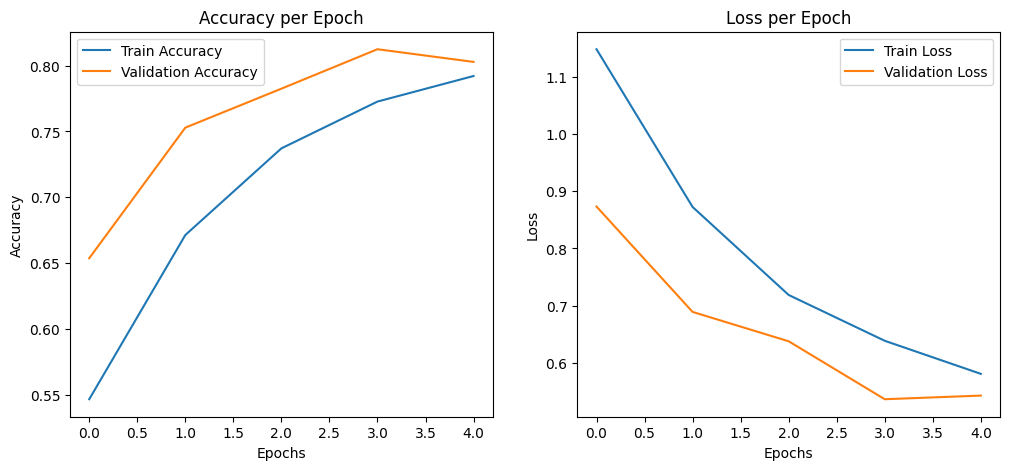

In [6]:
# Accuracy and Loss Graphs
import matplotlib.pyplot as plt

# Training and validation accuracy & loss plots
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Confusion Matrix & Classification Report

- **Predictions:** Obtained the model's predictions on the test data.  
- **Confusion Matrix:**  
  - Visualized the matrix comparing true vs predicted classes.  
  - Used `sns.heatmap` for a colored representation.  
- **Classification Report:**  
  - Calculated Precision, Recall, and F1-score.  
  - Displayed detailed performance for each class.

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step


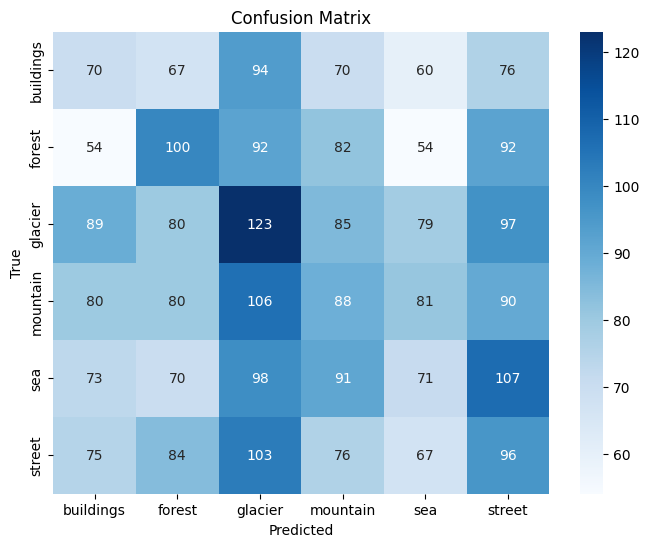

Classification Report:
              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       437
      forest       0.21      0.21      0.21       474
     glacier       0.20      0.22      0.21       553
    mountain       0.18      0.17      0.17       525
         sea       0.17      0.14      0.15       510
      street       0.17      0.19      0.18       501

    accuracy                           0.18      3000
   macro avg       0.18      0.18      0.18      3000
weighted avg       0.18      0.18      0.18      3000



In [7]:
#Confusion Matrix & Classification Report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predicts for test set
y_true = test_set.classes
y_pred_probs = cnn.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_set.class_indices.keys(), 
            yticklabels=test_set.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_set.class_indices.keys()))

## Grad-CAM Visualization

- **Purpose:** To visualize which regions of the image the model focuses on for its prediction.  
- **Steps:**  
  1. Created a heatmap from the last convolution layer using the `make_gradcam_heatmap` function.  
  2. Selected a sample image from the test set and normalized it.  
  3. Performed a forward pass through the model and generated the heatmap.  
  4. Superimposed the heatmap onto the original image (`superimposed_img`).  
- **Result:**  
  - Left: Original image.  
  - Right: Grad-CAM highlighting the regions the model focused on.

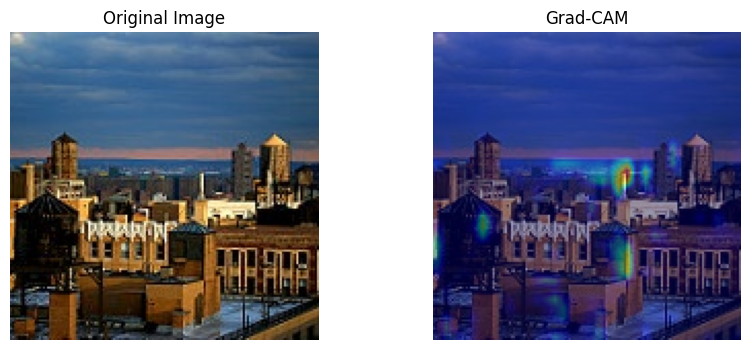

In [12]:
# Grad-CAM Visualization
import cv2

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Calculating gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Creating heatmap
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Selecting a sample test image
img_path = test_set.filepaths[10]   # 10th image from the test set
img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generating heatmap (last convolutional layer name could be "conv2d_2" → check with cnn.summary())
heatmap = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name="last_conv")

# Superimposing on the original image
img = cv2.imread(img_path)
img = cv2.resize(img, (150,150))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()